In [1]:
import parmed as pmd
import emcee
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from KDEpy import FFTKDE
from scipy import constants
from scipy.optimize import minimize


In [3]:
gmx = pmd.gromacs.GromacsTopologyFile("charmm/charmm_ff/forcefield.itp")
param_set = pmd.charmm.parameters.CharmmParameterSet.from_parameterset(gmx.parameterset)

In [ ]:
for cmap_type in param_set.cmap_types.values():
    print(np.exp(np.array(cmap_type.grid._data)).max())

In [29]:
mins = np.array([min(cmap_type.grid._data) for cmap_type in param_set.cmap_types.values()])

In [48]:
np.min(mins)

-7.05

(array([16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.]),
 array([-7.05   , -6.96559, -6.88118, -6.79677, -6.71236, -6.62795,
        -6.54354, -6.45913, -6.37472, -6.29031, -6.2059 ]),
 <BarContainer object of 10 artists>)

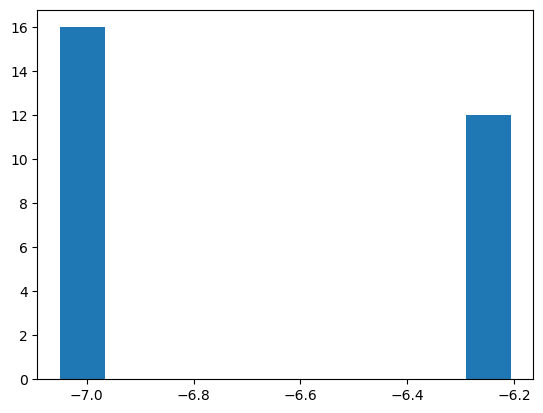

In [31]:
plt.hist(mins[mins< -6])

In [72]:

from scipy import constants
R = constants.R / (constants.calorie * 1e3)

RT = R * 300

-RT

-0.5961612775812619

In [73]:
np.exp(-7.05/RT) / np.finfo("float32").eps

61.35803395774314

1.1920929e-07

In [32]:
np.format_float_scientific(np.exp(-7.05))

'8.674089573070025e-04'

In [9]:
max(max(cmap_type.grid._data) for cmap_type in param_set.cmap_types.values())

12.1795

In [26]:
np.log(np.finfo("float32").eps)

-15.942385

In [23]:
np.finfo("float32").eps

1.1920929e-07

In [ ]:
param_set.cmap_types

In [ ]:

def build_logp(cmap_type):
    RT = 0.592 # kcal / mol
    # R = constants.R / (constants.calorie * 1e3)
    # RT = R * 298

    res = cmap_type.resolution
    V = np.array(cmap_type.grid).reshape(res, res)
    logp = -V / RT
    # logp = -V

    ext_logp = np.empty([dim + 1 for dim in logp.shape])

    ext_logp[:-1, :-1] = logp
    ext_logp[:-1, -1] = logp[:, 0]
    ext_logp[-1, :-1] = logp[0, :]
    ext_logp[-1, -1] = logp[0, 0]

    return ext_logp

logps = [build_logp(cmap_type) for cmap_type in param_set.cmap_types.values()]
# logps = [logp for logp in logps if np.exp(logp.min()) == 1.1615857613434818e-09]


In [ ]:
for logp in logps:
    print(logp.min())

In [ ]:
res = next(iter(logps)).shape[0]

angs = np.linspace(-np.pi, np.pi, res)
method = "slinear"

interps = [RegularGridInterpolator((angs, angs), logp, method=method) for logp in logps]


In [ ]:
def log_prob(x, interp):
    mask = np.any((x < -np.pi) | (x > np.pi), axis=1)
    x[mask, :] = np.array([0.0, 0.0])
    logp = interp(x)
    logp[mask] = -np.inf
    return logp

In [ ]:
from math import ceil

def sample(interp, nsamples):
    ndim = 2
    nwalkers = 32
    # nwalkers = 4
    samples_per_chain = ceil(nsamples / nwalkers)
    p0 = np.pi * (2 * np.random.rand(nwalkers, ndim) - 1)

    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=True)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[interp], vectorize=False)
    sampler.run_mcmc(p0, 1_000 + samples_per_chain)

    samples = sampler.get_chain()
    return samples[-samples_per_chain:].reshape(-1, 2)


samples_arr = []

for interp in interps:
    samples_arr.append(sample(interp, 600_000))
    # samples_arr.append(sample(interp, 1_000))

In [ ]:
sample(interp, 60_000)

In [ ]:
kernel = "gaussian"
factor = 10
l = (res - 1) * factor
angs = np.linspace(-np.pi, np.pi, l + 1)
kde_grid = np.stack(np.meshgrid(angs, angs, indexing="ij"), axis=-1).reshape(-1, 2)
assert np.allclose(angs[::factor], np.linspace(-np.pi, np.pi, res))

In [ ]:
def loss(x, samples, true_logp):
    # bw, eps = x
    (bw, k) = x
    # eps = 5.134644231712484e-06
    eps = 1.1615857613434818e-09
    kde = FFTKDE(bw=bw, kernel=kernel)
    kde.fit(samples)

    pdf = kde.evaluate(kde_grid).reshape(l + 1, l + 1)
    pdf = pdf[::factor, ::factor]

    # est_logp = np.log(pdf + np.exp(eps))
    est_logp = np.log(k * pdf + eps)

    return np.sum((est_logp[:-1, :-1] - true_logp[:-1, :-1]) ** 2)

# def cum_loss(x, samples_arr, logps):
#     tot = 0.0

#     for samples, true_logp in zip(samples_arr, logps):
#         tot += loss(x, samples, true_logp)

#     return tot

In [ ]:
# out = minimize(cum_loss, x0=[2e-1], bounds=[(1e-5, 10)], args=(samples_arr, logps))

In [ ]:
#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 74556.91129774158
#         x: [ 3.002e-01]
#       nit: 14
#       jac: [ 8.310e+03]
#      nfev: 298
#      njev: 149
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


#   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
#   success: True
#    status: 0
#       fun: 137949.50214250557
#         x: [ 4.544e-01]
#       nit: 6
#       jac: [ 1.224e+05]
#      nfev: 86
#      njev: 43
#  hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [ ]:
bws = []
# epses = []
for samples, true_logp in zip(samples_arr, logps):
    # out = minimize(loss, x0=[2e-1, 2.6e-6], bounds=[(1e-10, 10), (0, None)], args=(samples, true_logp))
    # out = minimize(loss, x0=[2e-1, -12], bounds=[(1e-5, 10), (None, 10)], args=(samples, true_logp))
    out = minimize(loss, x0=[2e-1, 1], bounds=[(1e-5, 10), (0, None)], args=(samples, true_logp))
    print(out.success, out.fun, out.x)
    if not out.success:
        print(out.message)
    # bw, eps = out.x
    (bw, k) = out.x
    # break
    bws.append(bw)
    # epses.append(eps)


bws = np.array(bws)
# epses = np.array(epses)

In [ ]:
plt.hist(bws)

In [ ]:
bws.mean(), bws.std()

In [ ]:
plt.plot(bws, epses, "o")
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.imshow(resampled_cmap.reshape(l, l).T, origin="lower", cmap="seismic", norm=CenteredNorm())
plt.colorbar()

In [ ]:
plt.imshow(grid.T, origin="lower", cmap="seismic", norm=CenteredNorm())
plt.colorbar()